## This file plots the final evaluation results for the trained models

In the default implementation, there is 24 simulation scenarios (two different edge server counts [20, 100], three different control topologies [CENTRALIZED, HYBRID, DECENTRALIZED], and four different edge device counts [1000, 2000, 3000, 4000]), and each of the scenarios has been run 5 times with the final trained models (i.e., five evaluation episodes). Different metrics (task execution time, task waiting time, task failures due to delay, tasks offloaded to edge, successfully executed tasks on edge and mist, network usage, CPU usage on edge and mist, energy consumption per server and per device, remaining battery on devices, cumulative return of edge server agents) are parsed from the simulation output for each scenario and episode. These metrics are averaged over the evaluation episodes for each scenario, after which the averages and their confidence intervals are plotted.

In [1]:
# Requirements
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import t
from os import listdir, makedirs
from os.path import join, exists

## Functions for result parsing

In [2]:
def parse_results_from_output_folders(list_of_folders, results):
    '''
    Parses evaluation results from a list of output folders to the provided 'results' dictionary.
    
    Each folder is assumed to contain the same number of evaluation episodes for a set of scenarios. Hence, it is checked 
    that each folder in the list has the same number of episodes. It is also assumed that the episodes (simulation runs) 
    in one folder have been run with the same simulation settings, meaning that for every episode inside the same folder, the 
    set of scenarios and the set of agents is assumed to be the same. Hence, it is checked for every output folder that the 
    number of scenarios in each episode and the number of agents in each scenario is the same. 
    
    A two-level nested dictionary that holds the evaluation results for every scenario and episode found in the output folders 
    will be created into the 'resuls' dictionary. In this case, one scenario inside an output folder consists of control 
    topology + edge device count combination. The documentation of the function 'parse_results_from_episodes' explains the 
    structure of this two-level nested dictionary.
    
    Args:
        list_of_folders (list): A list of output folders. All the folders are assumed to have the same number of episodes, 
                                but each folder holds the results for a different set of scenarios.
        results (dict): A dictionary to which the evaluation results parsed from the output folders will be added.
    
    Returns:
        Nothing.
    '''
    info = None
    for output in list_of_folders:
        output_info = get_output_information(output)
        if output_info == None:
            print('Please check the evaluation output in', output)
            break
        if info == None:
            info = output_info
        elif info['n_of_episodes'] != output_info['n_of_episodes']:
            print('The number of evaluation episodes in', output, 
                  'differs from the number of evaluation episodes in other output folders.')
            break
        parse_results_from_episodes(output, results)

def parse_results_from_episodes(output_dir, results):
    '''
    Parses evaluation metrics (task execution time, task waiting time, task failures due to delay, tasks offloaded to edge, 
    successfully executed tasks on edge and mist, network usage, CPU usage on edge and mist, energy consumption per server and 
    per device, dead device count, remaining battery on devices, cumulative return of the edge server agents) from the provided 
    output folder to the 'results' dictionary.
    
    Iterates through all the episodes in the 'output_dir', collecting metrics from each simulation scenario into the
    'results' dictionary. Creates a two-level nested dictionary into the provided 'results' dictionary. A key for each 
    control topology in an episode is added to the 'results' dictionary. The value for each control topology is another
    dictionary, where the keys correspond to different edge device counts in an episode (control topology + edge device 
    count together form one scenario). The value for each edge device count key is yet another dictionary, where keys are 
    evaluation metrics and values are 2D numpy arrays. The shape of the arrays is (n_of_episodes, 1) for every other
    metric except cumulative return, for which the shape is (n_of_episodes, n_of_agents).
    
    It is assumed that each episode in the output folder has been run with the same simulation settings, meaning that the 
    set of scenarios (control topology + edge device count combinations) in each episode and the set of agents in each 
    scenario is assumed to be the same.
    
    Args:
        output_dir (str): A path to a folder that contains simulation results for a number of episodes.
        results (dict): A dictionary to which results from the provided output folder will be added.
    
    Returns:
        Nothing.
    '''
    episode_folders = listdir(output_dir)
    paths_to_episode_folders = [join(output_dir, efolder) for efolder in episode_folders]
    
    for ei, path_to_efolder in enumerate(paths_to_episode_folders):
        csv_files = list(filter(lambda file_system_object: file_system_object.endswith('.csv'), listdir(path_to_efolder)))
        paths_to_csv_files = [join(path_to_efolder, file) for file in csv_files]
        
        for path_to_csv_file in paths_to_csv_files:
            sim_results = pd.read_csv(path_to_csv_file)
            parse_sim_results_for_each_scenario(sim_results, results, path_to_efolder, len(episode_folders), ei)
            
def parse_sim_results_for_each_scenario(sim_data, results, path_to_efolder, n_of_episodes, ei):
    '''
    Parses evaluation metrics (task execution time, task waiting time, task failures due to delay, tasks offloaded to edge, 
    successfully executed tasks on edge and mist, network usage, CPU usage on edge and mist, energy consumption per server 
    and per device, dead device count, remaining battery on devices) from each scenario in the provided data frame to the 
    'results' dictionary.
    
    The data frame 'sim_data' contains data from a csv file in an episode folder, the location of which is given by the 
    argument 'path_to_efolder'. Each row in this data frame provides simulation results for one scenario. The results from
    one scenario (a control topology + device count combination), will be added to the two-level nested dictionary inside 
    the 'results' dictionary. That is, the value for a metric is added to the 2D numpy array that is the value of  
    results[control][device_count][metric]. The index for the metric value in the array is [ei, 1], where 'ei' is the index
    of the current episode from which the sim_data was read from. If the 'results' dictionary does not already contain the 
    required keys and arrays, they will be created.
    
    Args:
        sim_data (pandas.core.frame.DataFrame): A data frame that contains simulation results for a number of scenarios.
        results (dict): A dictionary to which results from the provided data frame will be added.
        path_to_efolder (str): The path to the episode folder from which the 'sim_data' was read from.
        n_of_episodes (int): The total number of episodes.
        ei (int): The index of the current episode (the episode folder from which the 'sim_data' was read from).
    
    Returns:
        Nothing.
    '''
    for i in range(len(sim_data)):
        row = sim_data.iloc[i]
        architecture = row['Orchestration architecture']
        control = row['Orchestration algorithm']
        device_count = row['Edge devices count']
        n_of_tasks = row['Number of generated tasks'] - row['Tasks not generated due to the death of devices']
             
        results_per_control = results.get(control)
        if results_per_control == None:
            results.update({control: {}})
            results_per_control = results.get(control)
                    
        results_per_device_count = results_per_control.get(device_count)
        if results_per_device_count == None:
            results_per_control.update({
                device_count: {
                    'avgExecDelay': np.zeros((n_of_episodes,1)),
                    'avgWaitingTime': np.zeros((n_of_episodes,1)),
                    'tasksFailedDelay': np.zeros((n_of_episodes,1)),
                    'tasksOffloadedEdge': np.zeros((n_of_episodes, 1)),
                    'edgeSuccessRate': np.zeros((n_of_episodes,1)),
                    'mistSuccessRate': np.zeros((n_of_episodes,1)),
                    'netUsage': np.zeros((n_of_episodes,1)),
                    'wanUsage': np.zeros((n_of_episodes,1)),
                    'lanUsage': np.zeros((n_of_episodes,1)),
                    'manUsage': np.zeros((n_of_episodes,1)),
                    'avgNetUsage': np.zeros((n_of_episodes,1)),
                    'netTraffic': np.zeros((n_of_episodes,1)),
                    'avgBW': np.zeros((n_of_episodes,1)),
                    'avgCpuEdge': np.zeros((n_of_episodes,1)),
                    'avgCpuMist': np.zeros((n_of_episodes,1)),
                    'avgEnergyEdge': np.zeros((n_of_episodes,1)),
                    'avgEnergyMist': np.zeros((n_of_episodes,1)),
                    'deadDevices': np.zeros((n_of_episodes,1)),
                    'avgRemainingPower': np.zeros((n_of_episodes,1))
                }
                                        })
            results_per_device_count = results_per_control.get(device_count)
        
        results_per_device_count['avgExecDelay'][ei][0] = row['Average execution delay (s)']
        results_per_device_count['avgWaitingTime'][ei][0] = row['Average waiting time (s)']
        results_per_device_count['tasksFailedDelay'][ei][0] = round(100 * row['Tasks failed (delay)'] / n_of_tasks, 4)
        results_per_device_count['tasksOffloadedEdge'][ei][0] = round(100 * row['Total tasks executed (Edge)'] / n_of_tasks, 4)
        results_per_device_count['edgeSuccessRate'][ei][0] = round(100 * row['Tasks successfully executed (Edge)'] / 
                                                                  row['Total tasks executed (Edge)'], 4) 
        results_per_device_count['mistSuccessRate'][ei][0] = round(100 * row['Tasks successfully executed (Mist)'] / 
                                                                  row['Total tasks executed (Mist)'], 4)
        results_per_device_count['netUsage'][ei][0] = row['Network usage (s)']
        results_per_device_count['wanUsage'][ei][0] = row['Wan usage (s)']
        results_per_device_count['lanUsage'][ei][0] = row['Lan usage (s)']
        results_per_device_count['manUsage'][ei][0] = row['Network usage (s)'] - row['Wan usage (s)'] - row['Lan usage (s)']
        results_per_device_count['avgNetUsage'][ei][0] = row['Network usage (s)'] / row['Total tasks executed (Edge)']
        results_per_device_count['netTraffic'][ei][0] = row[' Total network traffic (MBytes)']
        results_per_device_count['avgBW'][ei][0] = row['Average bandwidth per task (Mbps)']
        results_per_device_count['avgCpuEdge'][ei][0] = row['Average CPU usage (Edge) (%)']
        results_per_device_count['avgCpuMist'][ei][0] = row['Average CPU usage (Mist) (%)']
        results_per_device_count['avgEnergyEdge'][ei][0] = row['Average Edge energy consumption (Wh/Data center)']
        results_per_device_count['avgEnergyMist'][ei][0] = row['Average Mist energy consumption (Wh/Device)']
        results_per_device_count['deadDevices'][ei][0] = row['Dead devices count']
        results_per_device_count['avgRemainingPower'][ei][0] = row['Average remaining power (%)']
        
        log_folder_for_scenario = '_'.join(['Pricelogs_scenario', control, architecture, str(device_count)])
        path_to_log_folder = join(path_to_efolder, log_folder_for_scenario)
        parse_cumulative_returns_for_scenario(results_per_device_count, path_to_log_folder, n_of_episodes, ei)
        
def parse_cumulative_returns_for_scenario(results_for_scenario, path_to_log_folder, n_of_episodes, ei):
    '''
    Parses the cumulative return of each agent in a scenario to the provided 'results_for_scenario' dictionary.
    
    Each scenario in an episode has their own price log folder inside the episode folder. The price log folder contains the
    price log files for each agent in the scenario. The cumulative return of each agent is parsed from these files and added 
    to the 'results_for_scenario' dictionary. That is, the value of the cumulative return is added to the 2D numpy array 
    that is the value of results_for_scenario['cumulativeReturn']. The index for the cumulative return in the array is [ei, ai], 
    where 'ei' is the index of the current episode and 'ai' is the index of the agent. If the 'results_for_scenario' dictionary 
    does not already contain the required key and array, they will be created.
    
    Args:
        results_for_scenario (dict): A dictionary to which results from the provided log folder will be added.
        path_to_log_folder (str): The path to the log folder that contains all the agent price logs for a scenario.
        n_of_episodes (int): The total number of episodes.
        ei (int): The index of the current episode (the episode folder in which the provided log folder resides).
    
    Returns:
        Nothing.
    '''
    log_files = listdir(path_to_log_folder)
    n_of_agents = len(log_files)
    agent_names = sorted(list(map(lambda log_file: log_file.split('_')[0], log_files)), 
                                     key=get_agent_number_from_name)
    cumulative_return_array = results_for_scenario.get('cumulativeReturn')
    if not isinstance(cumulative_return_array, np.ndarray):
        results_for_scenario.update({'cumulativeReturn': np.zeros((n_of_episodes, n_of_agents))})
        cumulative_return_array = results_for_scenario.get('cumulativeReturn')
        
    paths_to_log_files = [join(path_to_log_folder, log_file) for log_file in log_files]
            
    for li, path_to_lfile in enumerate(paths_to_log_files):
                
        agent_name = log_files[li].split('_')[0]
        ai = agent_names.index(agent_name)
                
        agent_data = pd.read_csv(path_to_lfile)
        cumulative_return_array[ei][ai] = agent_data.CumulativeProfit.iat[-1]

In [3]:
def get_output_information(output_dir):
    '''
    Parses output information from an output directory. The information comprises the number of episodes (simulation runs) 
    in the output folder, the number and names of the agents in the simulation environment, as well as the number and names
    of the simulation scenarios. It is assumed that all the episodes inside the given output directory have been run with 
    the same simulation settings (the same set of agents, the same set of scenarios), hence it is checked that the number 
    of scenarios in each episode and the number of agents in each scenario is the same.
    
    Args:
        output_dir (str): A directory that contains simulation results for a number of episodes.
        
    Returns:
        dict or NoneType: A dictionary that contains information about the simulation output (number of episodes, number
                          of agents, agent names, number of scenarios, scenario names). None is returned if the given folder 
                          does not contain any episodes or if it is detected that the number of scenarios in all episodes or 
                          the number of agents in all scenarios is not the same.
    '''
    info = {}
    
    episode_folders = listdir(output_dir)
    if len(episode_folders) == 0:
        print('No episodes found in the given output folder.')
        return
    info['n_of_episodes'] = len(episode_folders)
    
    paths_to_episode_folders = [join(output_dir, efolder) for efolder in episode_folders]
    scenario_names = set()
    agent_names = set()
    n_of_scenarios = 0
    n_of_agents = 0
    
    for path_to_efolder in paths_to_episode_folders:
        log_folders = list(filter(lambda file_system_object: 'Pricelogs' in file_system_object, listdir(path_to_efolder)))
        
        if n_of_scenarios != 0 and len(log_folders) != n_of_scenarios:
            print('The number of scenarios in', path_to_efolder, 
                  'differs from the number of scenarios in other episode folders.')
            return
        else:
            n_of_scenarios = len(log_folders)
            
        scenario_names.update(list(map(lambda log_folder: '_'.join(log_folder.split('_')[2:]), log_folders)))
        paths_to_log_folders = [join(path_to_efolder, lfolder) for lfolder in log_folders]
        
        for path_to_lfolder in paths_to_log_folders:
            log_files = listdir(path_to_lfolder)
            
            if n_of_agents != 0 and len(log_files) != n_of_agents:
                print('The number of agent price log files in', path_to_lfolder, 
                      'differs from the number of agent price log files in other price log folders.')
                return
            else:
                n_of_agents = len(log_files)
            
            agent_names.update(list(map(lambda log_file: log_file.split('_')[0], log_files)))
    
    info['n_of_agents'] = n_of_agents
    info['agent_names'] = sorted(list(agent_names), key=get_agent_number_from_name)
    info['n_of_scenarios'] = n_of_scenarios
    info['scenario_names'] = sorted(list(scenario_names), key=lambda n: int(n.split('_')[-1]))
    
    return info

def get_agent_number_from_name(name):
    '''
    Gets the the number of an agent from its name. It is assumed that the name of an agent ends with a number that can 
    be anything between 0 and 999. E.g., for name 'dc54' the integer 54 is returned.
    
    Args:
        name (str): The name of the edge server agent.
        
    Returns:
        int: The number of the agent.
    '''
    try:
        return int(name[-3:])
    except ValueError:
        try:
            return int(name[-2:])
        except ValueError:
            return int(name[-1])

## Functions for result plotting

In [4]:
def plot_eval_results(evaluation_results, fpath=None, confidence_level=0.95):
    '''
    Plots and saves the figures for each evaluation metric and main scenario found in the provided 'evaluation_results' 
    dictionary.
    
    'evaluation_results' is assumed to be a three-level nested dictionary, where the first keys correspond to some main
    scenarios (20 servers or 100 servers in this case). The keys in the first nested dictionary correspond to the orchestration 
    algorithms used in EISim (in this case these are control topologies: decentralized, hybrid or centralized), and the 
    keys in the second nested dictionary correspond to the edge device counts used in the simulations. The keys in the third 
    nested dictionary correspond to evaluation metrics, and the values are 2D numpy arrays of shape (n_of_episodes, 1) (or 
    (n_of_episodes, n_of_agents) for cumulative return). These arrays hold the metric values for each evaluation episode (and 
    each agent in the case of cumulative return). 
    In other words, one whole simulation scenario consists of main scenario + control topology + edge device count combination. 
    The dictionary found at evaluation_results[main_scenario][control][device_count] contains all the evaluation metrics 
    and their values in a number of evaluation episodes for the scenario defined by main_scenario + control + device_count.
    
    Each main scenario gets its own set of plots. For one main scenario, every evaluation metric gets its own plot. In this 
    plot, each control topology has its own element (line or bar group), and x-axis values correspond to edge device counts. 
    The y-axis value for a control topology + edge device count combination is the average of the evaluation metric over the 
    evaluation episodes. The confidence interval of this average is also plotted.
    
    Args:
        evaluation_results (dict): A three-level nested dictionary that holds the evaluation metrics for each scenario and 
                                   evaluation episode.
        fpath (str): A path to a folder where all the figures will be saved. By default, the figures are saved to the current 
                     working directory.
        confidence_level (float): The confidence level for the confidence interval. Default is 0.95.
    
    Returns:
        Nothing.
    '''
    
    # Iterate through main scenarios ('20 servers' and '100 servers')
    for main_scenario, control_results in evaluation_results.items():
        
        control_topologies = list(control_results.keys()) # 'Decentralized', 'hybrid' and 'centralized'
        x_labels = sorted(list(control_results[control_topologies[0]].keys())) # Device counts
        metrics = list(control_results[control_topologies[0]][x_labels[0]].keys())
        n_of_episodes = len(control_results[control_topologies[0]][x_labels[0]][metrics[0]])
        t_value = t.interval(confidence_level, n_of_episodes-1)[1]
        
        # Create a two-level nested dictionary, where
            # 1. Keys are evaluation metrics
            # 2. The keys of the first nested dictionary are control topologies
            # 3. The second nested dictionary has two keys
                # - 'mean': holds an array of average evaluation metric values for each edge device count
                # - 'ci': holds the widths of the confidence intervals for the averages
        metric_means_and_CIs = {
            metric: {
                control: {
                    'mean': np.array([control_results[control][device_count][metric].sum(axis=1).mean() 
                                      for device_count in x_labels
                                     ]),
                    'ci': np.array([t_value * 
                                    (control_results[control][device_count][metric].sum(axis=1).std() / np.sqrt(n_of_episodes))
                                    for device_count in x_labels
                                   ])
                    
                } for control in control_topologies
            } for metric in metrics
        }
        
        # Plot each metric
        #markers=['o', 'X', 's']
        plot_metric_as_bar_chart(metric_means_and_CIs['avgExecDelay'], 
                                 x_labels, 
                                 'Device count', 
                                 'Seconds', 
                                 f'Average execution delay per task\n({main_scenario})',
                                 f'avgExecDelay({main_scenario}).pdf',
                                 lambda value: round(value, 3),
                                 None,
                                 fpath
                                )
        plot_metric_as_bar_chart(metric_means_and_CIs['avgWaitingTime'], 
                                 x_labels, 
                                 'Device count', 
                                 'Seconds', 
                                 f'Average waiting time per task\n({main_scenario})',
                                 f'avgWaitingTime({main_scenario}).pdf',
                                 lambda value: round(value, 3),
                                 None,
                                 fpath
                                )
        plot_metric_as_bar_chart(metric_means_and_CIs['tasksFailedDelay'], 
                                 x_labels, 
                                 'Device count', 
                                 '', 
                                 f'Percentage of tasks failed due to high delay\n({main_scenario})',
                                 f'tasksFailedDelay({main_scenario}).pdf',
                                 lambda value: f'{round(value, 2)}%',
                                 lambda y, pos: f'{y}%',
                                 fpath
                                )
        plot_metric_as_bar_chart(metric_means_and_CIs['tasksOffloadedEdge'], 
                                 x_labels, 
                                 'Device count',
                                 '',
                                 f'Percentage of tasks offloaded to edge\n({main_scenario})',
                                 f'tasksOffloadedEdge({main_scenario}).pdf',
                                 lambda value: f'{round(value, 2)}%',
                                 lambda y, pos: f'{y}%',
                                 fpath
                                )
        plot_metric_as_bar_chart(metric_means_and_CIs['edgeSuccessRate'], 
                                 x_labels, 
                                 'Device count', 
                                 '', 
                                 f'Percentage of tasks succesfully executed on edge servers\n({main_scenario})',
                                 f'edgeSuccessRate({main_scenario}).pdf',
                                 lambda value: f'{round(value, 2)}%',
                                 lambda y, pos: f'{y}%',
                                 fpath
                                )
        plot_metric_as_bar_chart(metric_means_and_CIs['mistSuccessRate'], 
                                 x_labels, 
                                 'Device count', 
                                 '', 
                                 f'Percentage of tasks succesfully executed on devices\n({main_scenario})',
                                 f'mistSuccessRate({main_scenario}).pdf',
                                 lambda value: f'{round(value, 2)}%',
                                 lambda y, pos: f'{y}%',
                                 fpath
                                )
        plot_metric_as_bar_chart(metric_means_and_CIs['netUsage'], 
                                 x_labels, 
                                 'Device count', 
                                 'Seconds', 
                                 f'Total network usage in seconds\n({main_scenario})',
                                 f'netUsage({main_scenario}).pdf',
                                 lambda value: round(value, 3),
                                 None,
                                 fpath
                                )
        plot_metric_as_bar_chart(metric_means_and_CIs['wanUsage'], 
                                 x_labels, 
                                 'Device count', 
                                 'Seconds', 
                                 f'Total WAN usage in seconds\n({main_scenario})',
                                 f'wanUsage({main_scenario}).pdf',
                                 lambda value: round(value, 3),
                                 None,
                                 fpath
                                )
        plot_metric_as_bar_chart(metric_means_and_CIs['lanUsage'], 
                                 x_labels, 
                                 'Device count', 
                                 'Seconds', 
                                 f'Total LAN usage in seconds\n({main_scenario})',
                                 f'lanUsage({main_scenario}).pdf',
                                 lambda value: round(value, 3),
                                 None,
                                 fpath
                                )
        plot_metric_as_bar_chart(metric_means_and_CIs['manUsage'], 
                                 x_labels, 
                                 'Device count', 
                                 'Seconds', 
                                 f'Total MAN usage in seconds\n({main_scenario})',
                                 f'manUsage({main_scenario}).pdf',
                                 lambda value: round(value, 3),
                                 None,
                                 fpath
                                )
        plot_metric_as_bar_chart(metric_means_and_CIs['avgNetUsage'], 
                                 x_labels, 
                                 'Device count', 
                                 'Seconds', 
                                 f'Average network usage per offloaded task\n({main_scenario})',
                                 f'avgNetUsage({main_scenario}).pdf',
                                 lambda value: round(value, 3),
                                 None,
                                 fpath
                                )
        plot_metric_as_bar_chart(metric_means_and_CIs['netTraffic'], 
                                 x_labels, 
                                 'Device count', 
                                 'MB', 
                                 f'Total network traffic in megabytes\n({main_scenario})',
                                 f'netTraffic({main_scenario}).pdf',
                                 lambda value: round(value),
                                 None,
                                 fpath
                                )
        plot_metric_as_bar_chart(metric_means_and_CIs['avgBW'], 
                                 x_labels, 
                                 'Device count', 
                                 'Mbps', 
                                 f'Average bandwidth per task\n({main_scenario})',
                                 f'avgBW({main_scenario}).pdf',
                                 lambda value: round(value, 1),
                                 None,
                                 fpath
                                )
        plot_metric_as_bar_chart(metric_means_and_CIs['avgCpuEdge'], 
                                 x_labels, 
                                 'Device count', 
                                 '', 
                                 f'Average CPU usage on edge servers\n({main_scenario})',
                                 f'avgCpuEdge({main_scenario}).pdf',
                                 lambda value: f'{round(value, 2)}%',
                                 lambda y, pos: f'{y}%',
                                 fpath
                                )
        plot_metric_as_bar_chart(metric_means_and_CIs['avgCpuMist'], 
                                 x_labels, 
                                 'Device count', 
                                 '', 
                                 f'Average CPU usage on devices\n({main_scenario})',
                                 f'avgCpuMist({main_scenario}).pdf',
                                 lambda value: f'{round(value, 2)}%',
                                 lambda y, pos: f'{y}%',
                                 fpath
                                )
        plot_metric_as_bar_chart(metric_means_and_CIs['avgEnergyEdge'], 
                                 x_labels, 
                                 'Device count', 
                                 'Wh', 
                                 f'Average energy consumption per edge server\n({main_scenario})',
                                 f'avgEnergyEdge({main_scenario}).pdf',
                                 lambda value: round(value, 2),
                                 None,
                                 fpath
                                )
        plot_metric_as_bar_chart(metric_means_and_CIs['avgEnergyMist'], 
                                 x_labels, 
                                 'Device count', 
                                 'Wh', 
                                 f'Average energy consumption per device\n({main_scenario})',
                                 f'avgEnergyMist({main_scenario}).pdf',
                                 lambda value: round(value, 2),
                                 None,
                                 fpath
                                )
        plot_metric_as_bar_chart(metric_means_and_CIs['deadDevices'], 
                                 x_labels, 
                                 'Device count', 
                                 '', 
                                 f'Dead device count\n({main_scenario})',
                                 f'deadDevices({main_scenario}).pdf',
                                 lambda value: round(value, 2),
                                 None,
                                 fpath
                                )
        plot_metric_as_bar_chart(metric_means_and_CIs['avgRemainingPower'], 
                                 x_labels, 
                                 'Device count',
                                 '',
                                 f'Average remaining power per device\n({main_scenario})',
                                 f'avgRemainingPower({main_scenario}).pdf',
                                 lambda value: f'{round(value, 2)}%',
                                 lambda y, pos: f'{y}%',
                                 fpath
                                )
        plot_metric_as_bar_chart(metric_means_and_CIs['cumulativeReturn'], 
                                 x_labels, 
                                 'Device count', 
                                 '', 
                                 f'Cumulative return for the whole edge platform\n({main_scenario})',
                                 f'cumulativeReturn({main_scenario}).pdf',
                                 lambda value: f'{round(value * 1e-6, 2)}M',
                                 format_y_labels,
                                 fpath
                                )
                    
def plot_metric_as_line_chart(means_and_CIs, xtick_labels, x_label, y_label, title, markers, fname,
                              y_label_formatter=None, fpath=None):
    '''
    Plots the provided metric means and confidence intervals as a line chart.
    
    'means_and_CIs' is assumed to be a nested dictionary that holds, for each simulation scenario, the means and confidence 
    interval widths of the metric that is plotted. Each key in this dictionary gets its own element (line) in the plot. In this 
    case, these keys are control topologies. The keys of the nested dictionary must be 'mean' and 'ci', the values of which are 
    1D numpy arrays that must be the same length as 'xtick_labels'. 'xtick_labels' in this case are edge device counts, and the
    value array for the key 'mean' holds the average metric value for each edge device count. The key 'ci' holds an array of
    the widths for the confidence intervals.
    
    Args:
        means_and_CIs (dict): A dictionary that holds the means and confidence interval widths of the metric for each 
                              simulation scenario (control topology + device count combination).
        xtick_labels (list): A list of labels for the x-axis ticks.
        x_label (str): A label for x-axis.
        y_label (str): A label for y-axis.
        title (str): A title for the figure.
        markers (list): A list of marker styles for each line in the plot. Must be the same length as the number of keys 
                        in 'means_and_CIs' dictionary.
        fname (str): A file name for saving the figure (in PDF format).
        y_label_formatter (function): A function that takes the data value and position of a y-axis label as input and
                                      returns a formatted label. By default, no formatter is used.
        fpath (str): A path to a folder where the figure will be saved. By default, the figure is saved to the current 
                     working directory.
    
    Returns:
        Nothing.
    '''
    x = np.arange(len(xtick_labels))  # The x-axis label locations
    fig, ax = plt.subplots(figsize=(11, 5))

    for i, (control, results) in enumerate(means_and_CIs.items()):
        
        mean_upper = results['mean'] + results['ci']
        mean_lower = results['mean'] - results['ci']
        
        ax.plot(x, results['mean'], label=control, marker=markers[i], markersize=8)
        ax.fill_between(x, mean_lower, mean_upper, alpha=0.2)

    
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title, fontsize=13)
    ax.set_xticks(x, xtick_labels)
    ax.grid(True, 'major', 'y', linewidth=0.5, c='k', alpha=0.3)
    if y_label_formatter != None:
        ax.get_yaxis().set_major_formatter(FuncFormatter(y_label_formatter))
        
    # Gets the tight bounding box of the x axis, including the axis and its decorators (x label, tick labels).
    x_bbox = ax.get_xaxis().get_tightbbox(fig.canvas.get_renderer())
    # Gives the bottom left corner of the box in axis coordinates
    _, ymin = ax.transAxes.inverted().transform(x_bbox.min) 
    # The legend is placed below the figure, ymin is used to avoid placing on top of x tick labels
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, ymin), ncol=5)
    
    fig.tight_layout()

    if fpath != None:
        if not exists(fpath):
            makedirs(fpath)
        fname = join(fpath, fname)
            
    plt.savefig(fname, format='pdf', bbox_inches='tight')
    plt.show()
    
def plot_metric_as_bar_chart(means_and_CIs, xtick_labels, x_label, y_label, title, fname,
                             bar_label_formatter=None, y_label_formatter=None, fpath=None):
    '''
    Plots the provided metric means and confidence intervals as a grouped bar chart.
    
    'means_and_CIs' is assumed to be a nested dictionary that holds, for each simulation scenario, the means and confidence 
    interval widths of the metric that is plotted. Each key in this dictionary gets its own element (group) in the plot. In this 
    case, these keys are control topologies. The keys of the nested dictionary must be 'mean' and 'ci', the values of which are 
    1D numpy arrays that must be the same length as 'xtick_labels'. 'xtick_labels' in this case are edge device counts, and the
    value array for the key 'mean' holds the average metric value for each edge device count. The key 'ci' holds an array of
    the widths for the confidence intervals.
    
    Args:
        means_and_CIs (dict): A dictionary that holds the means and confidence interval widths of the metric for each 
                              simulation scenario (control topology + device count combination).
        xtick_labels (list): A list of labels for the x-axis ticks.
        x_label (str): A label for x-axis.
        y_label (str): A label for y-axis.
        title (str): A title for the figure.
        fname (str): A file name for saving the figure (in PDF format).
        bar_label_formatter (function): A function that takes the data value of a bar label as an input and returns a 
                                        formatted label. By default, no formatter is used.
        y_label_formatter (function): A function that takes the data value and position of a y-axis label as input and
                                      returns a formatted label. By default, no formatter is used.
        fpath (str): A path to a folder where the figure will be saved. By default, the figure is saved to the current 
                     working directory.
    
    Returns:
        Nothing.
    '''
    x = np.arange(len(xtick_labels))  # the label locations
    width = 0.3  # the width of the bars
    multiplier = 0
    n_of_bars = len(means_and_CIs.keys())
    
    fig, ax = plt.subplots(figsize=(12, 5))

    for control, results in means_and_CIs.items():
        
        mean_upper = results['mean'] + results['ci']
        mean_lower = results['mean'] - results['ci']
        
        offset = width * multiplier
        bars = ax.bar(x + offset, results['mean'], width, label=control, alpha=0.9)
        
        if bar_label_formatter != None:
            bar_labels = [bar_label_formatter(value) for value in bars.datavalues]
        else:
            bar_labels = bars.datavalues
            
        ax.bar_label(bars, label_type='center', padding=8, labels=bar_labels, fontsize=9)
        ax.plot((x + offset, x + offset), (mean_lower, mean_upper), color='k', linewidth=5)
        
        multiplier += 1

    
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title, fontsize=13)
    ax.set_xticks(x + 0.5 * width * (n_of_bars-1), xtick_labels)
    ax.grid(True, 'major', 'y', linewidth=0.5, c='k', alpha=0.3)
    if y_label_formatter != None:
        ax.get_yaxis().set_major_formatter(FuncFormatter(y_label_formatter))
        
    # Gets the tight bounding box of the x axis, including the axis and its decorators (x label, tick labels).
    x_bbox = ax.get_xaxis().get_tightbbox(fig.canvas.get_renderer())
    # Gives the bottom left corner of the box in axis coordinates
    _, ymin = ax.transAxes.inverted().transform(x_bbox.min) 
    # The legend is placed below the figure, ymin is used to avoid placing on top of x tick labels
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, ymin), ncol=5)
    
    fig.tight_layout()
    
    if fpath != None:
        if not exists(fpath):
            makedirs(fpath)
        fname = join(fpath, fname)
            
    plt.savefig(fname, format='pdf', bbox_inches='tight')
    plt.show()
    
def format_y_labels(value, position):
    '''
    Formats the y-axis labels for the Matplotlib figures.
    
    Args:
        value (numpy.float64): Y label.
        position (int): The position of the label.
    
    Returns:
        str: Formatted y label.
    '''
    if value == 0:
        return str(int(value))
    return f'{round(value * 1e-6, 3)}M'

## Plotting the results

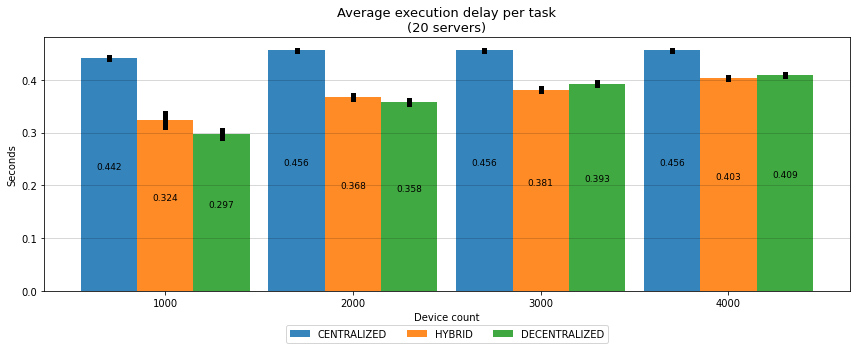

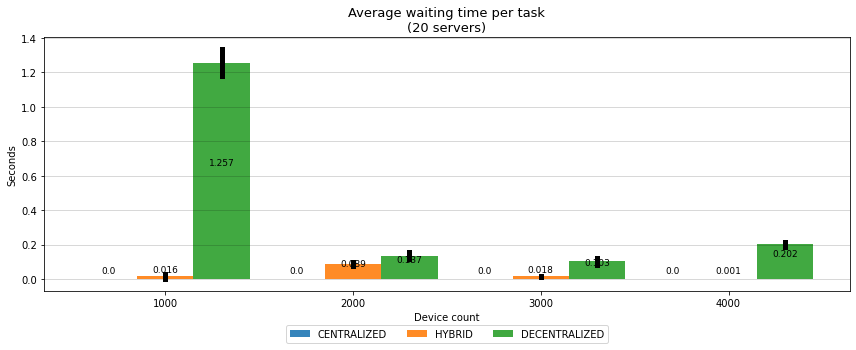

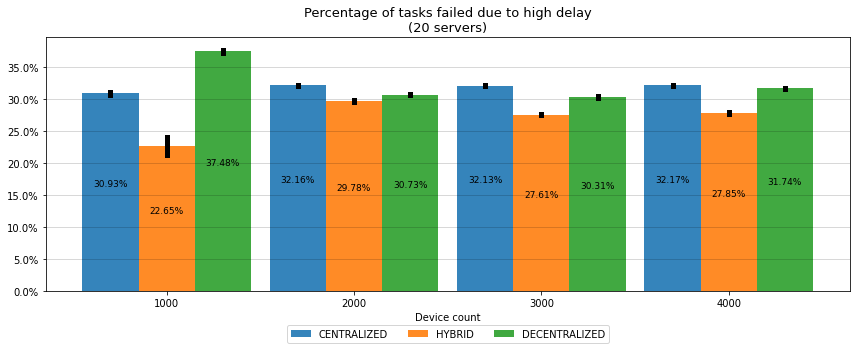

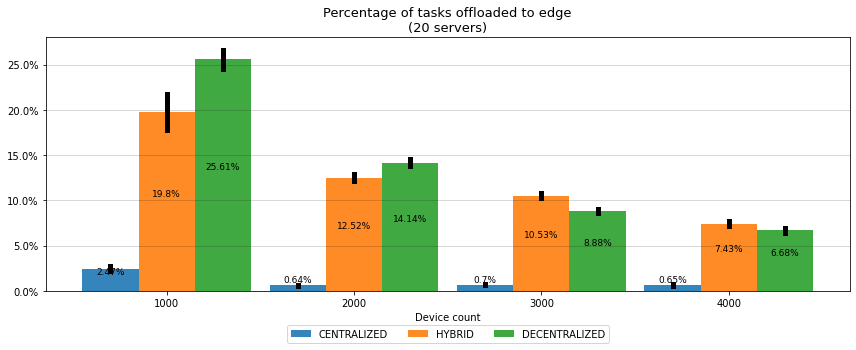

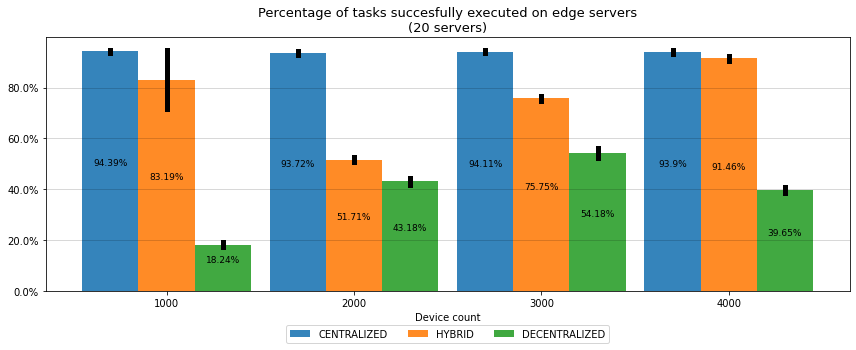

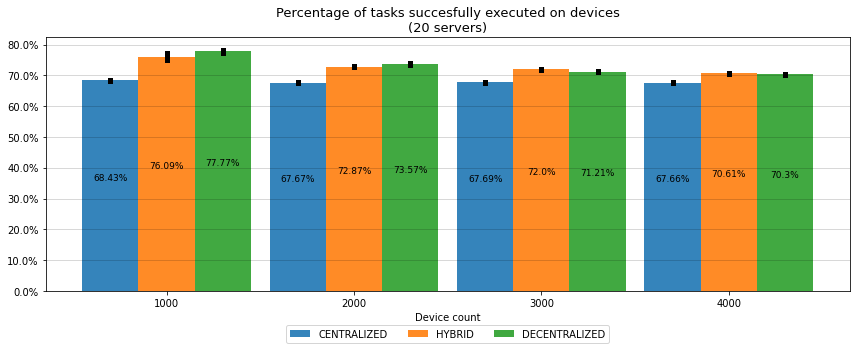

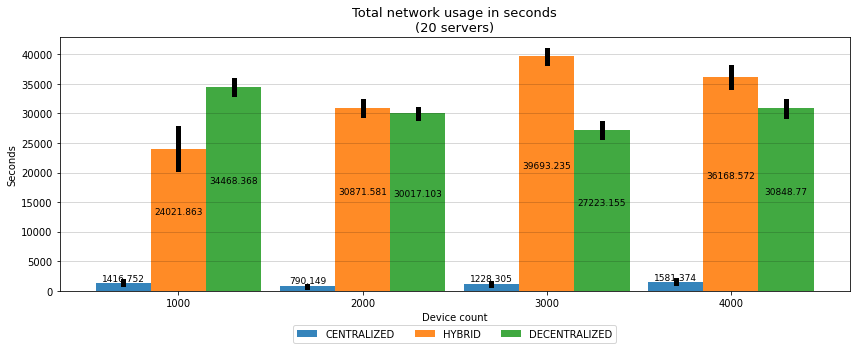

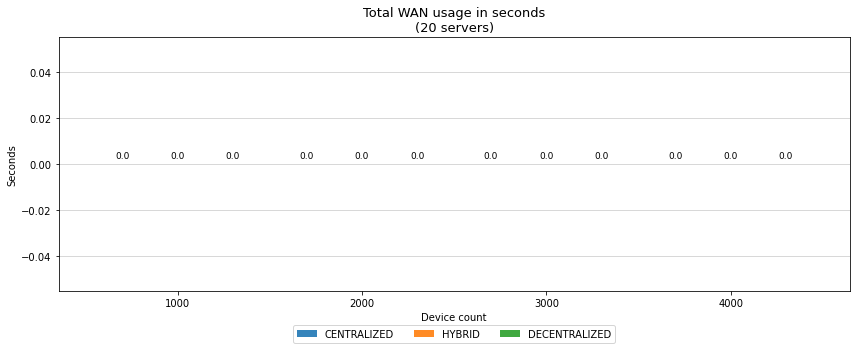

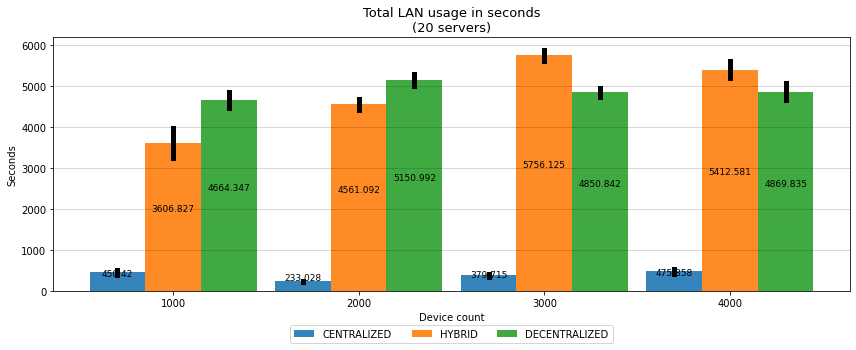

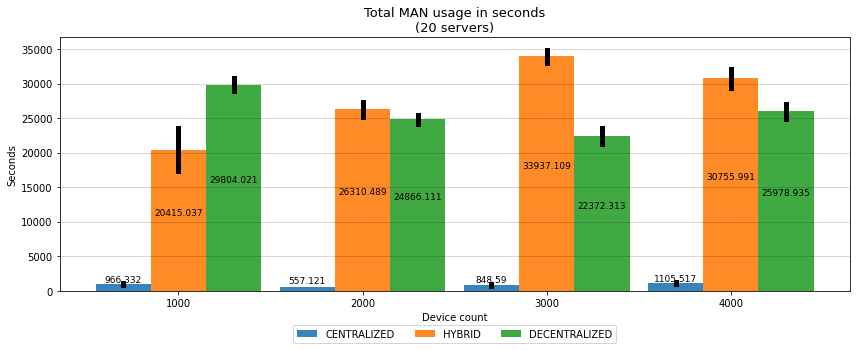

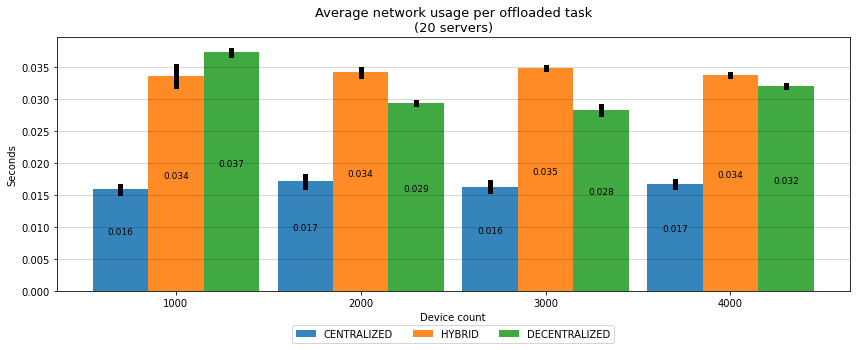

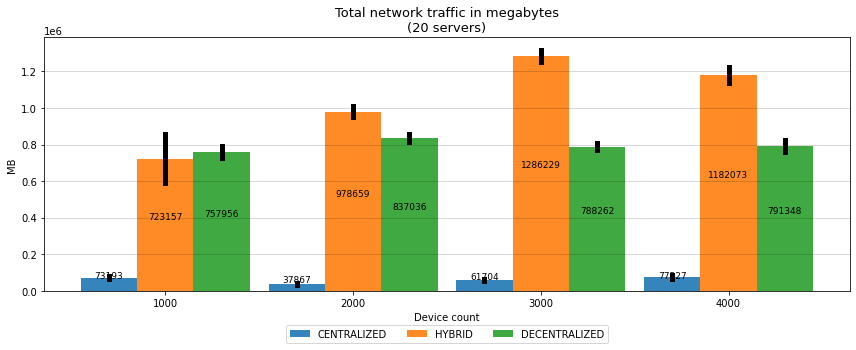

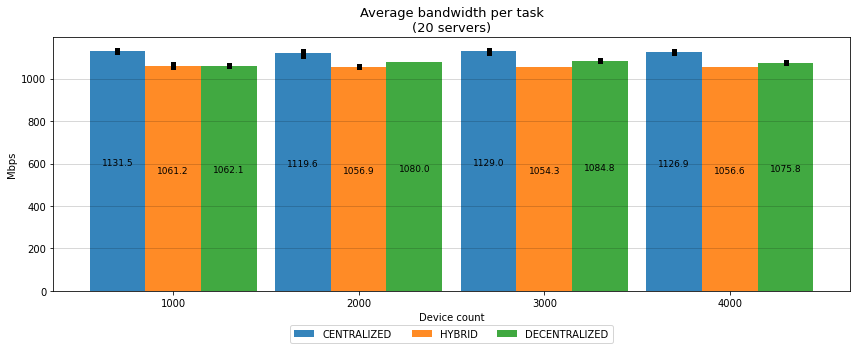

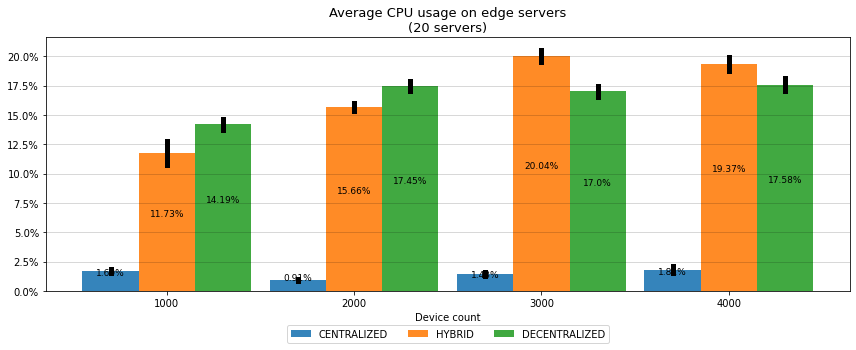

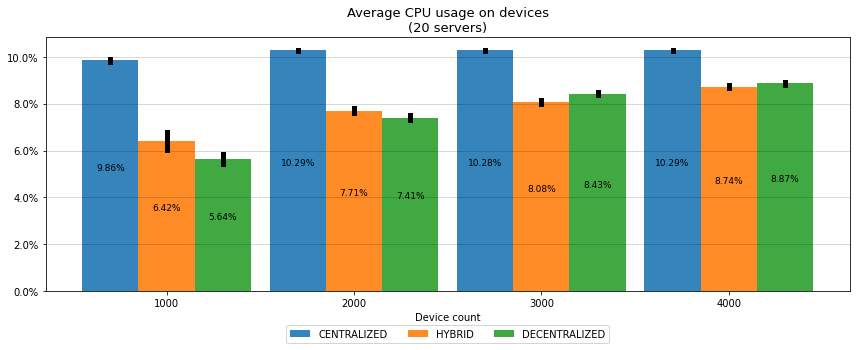

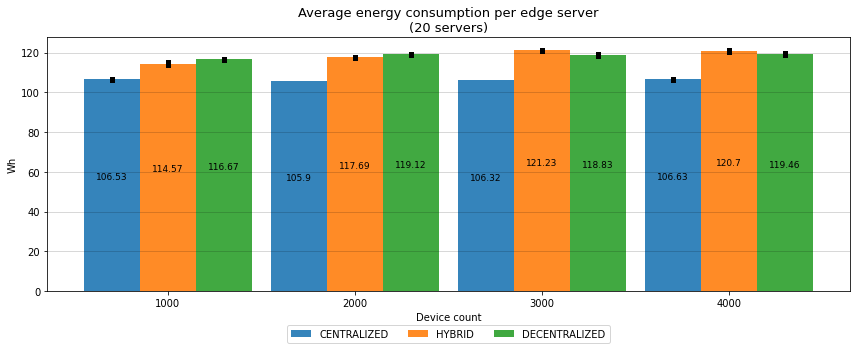

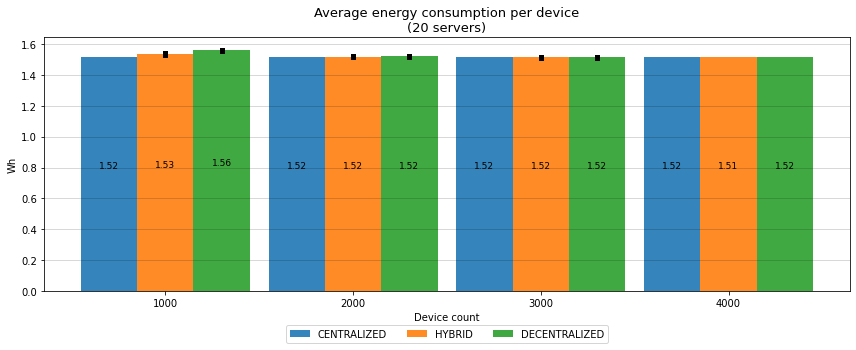

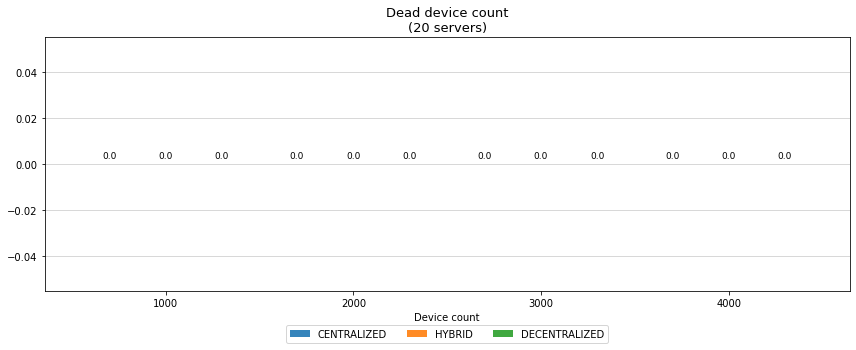

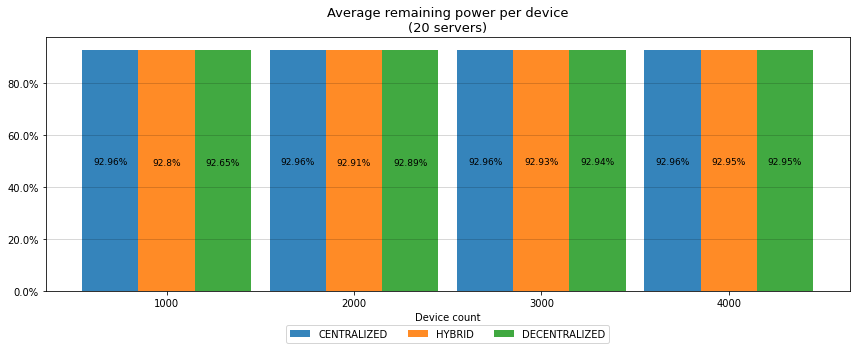

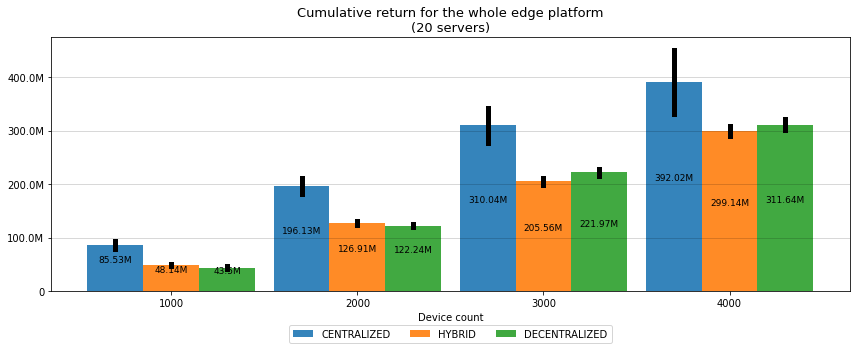

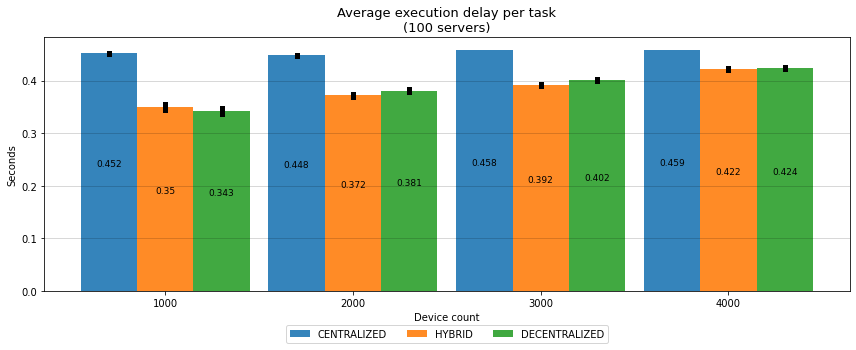

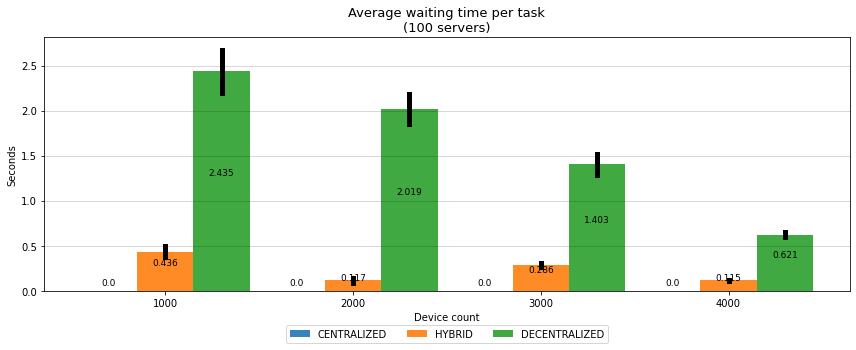

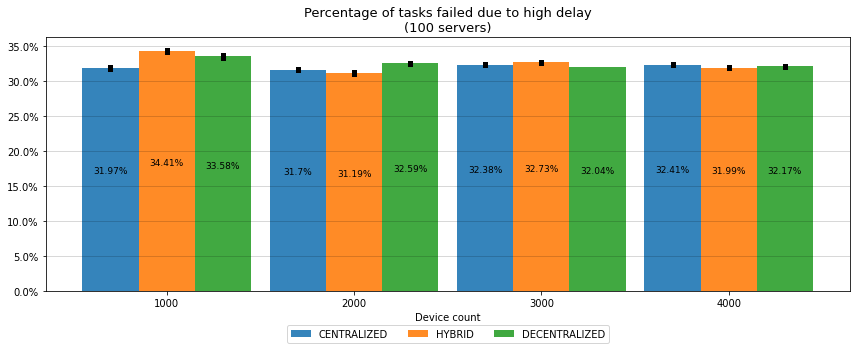

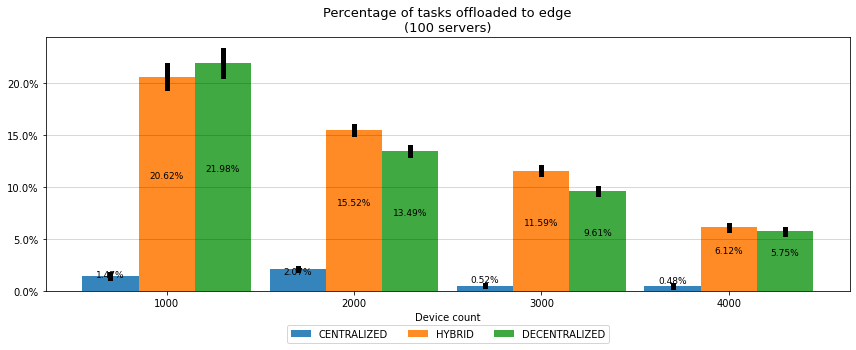

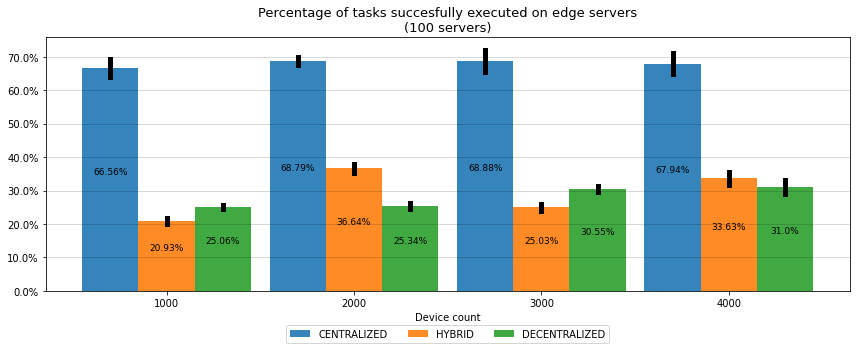

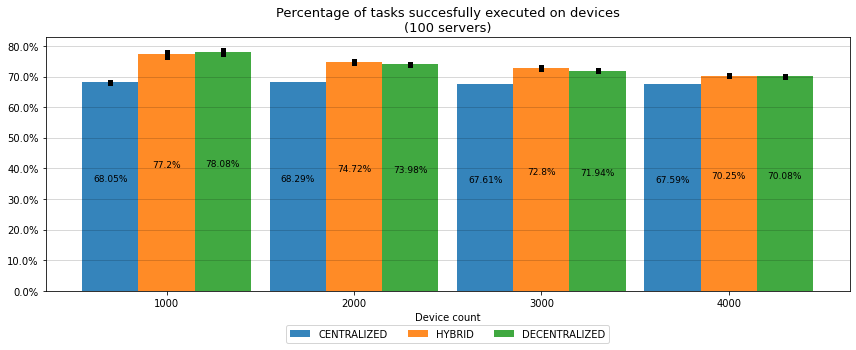

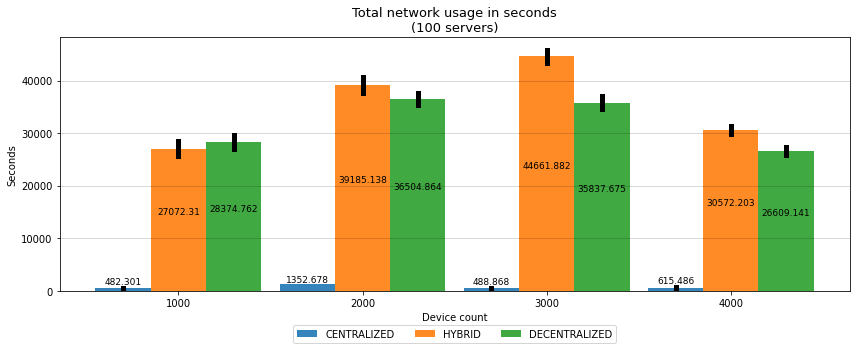

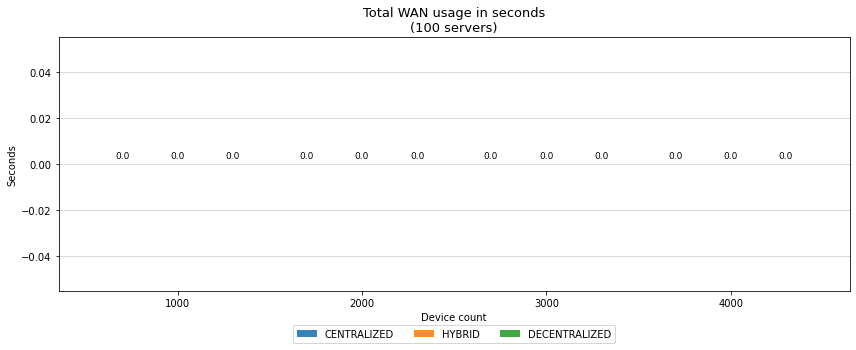

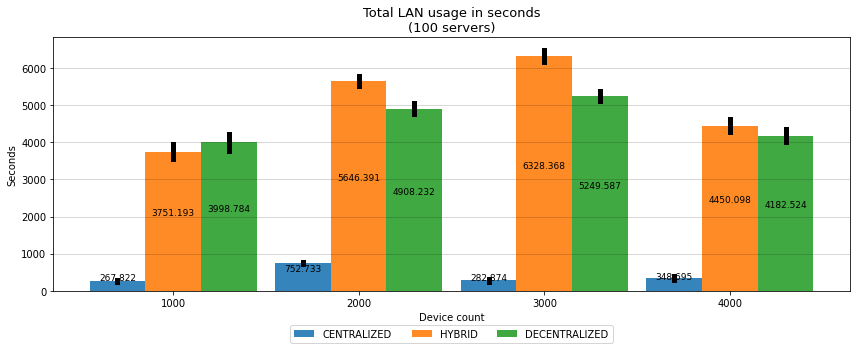

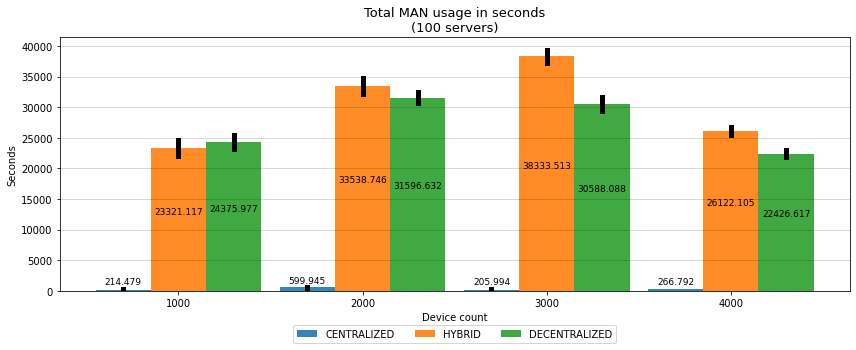

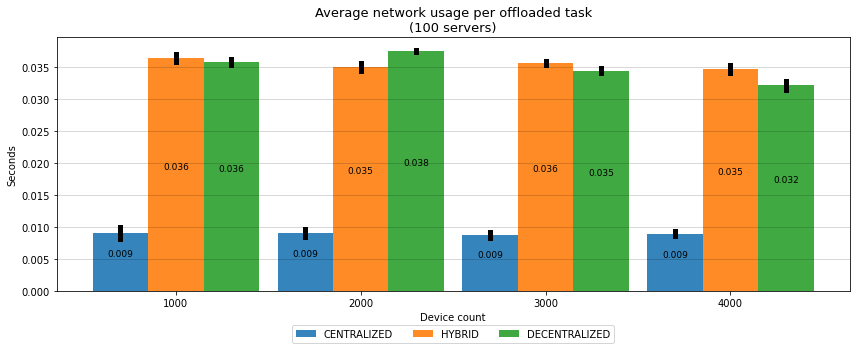

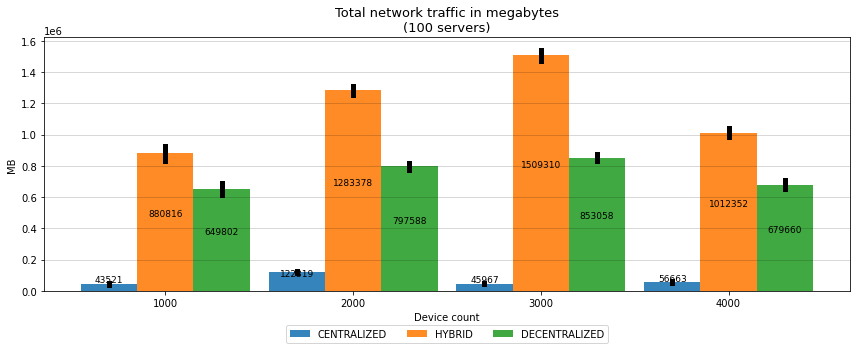

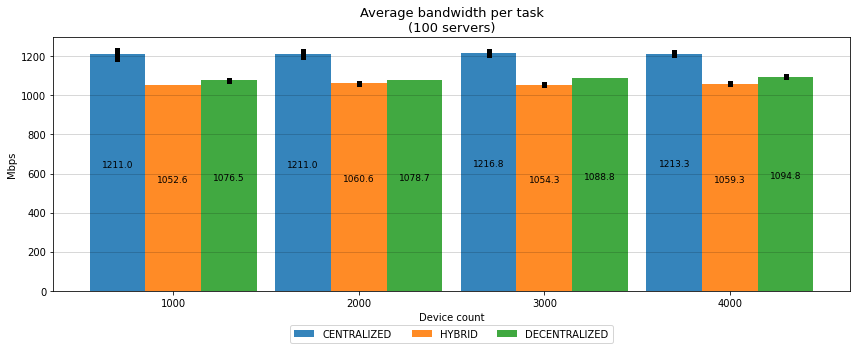

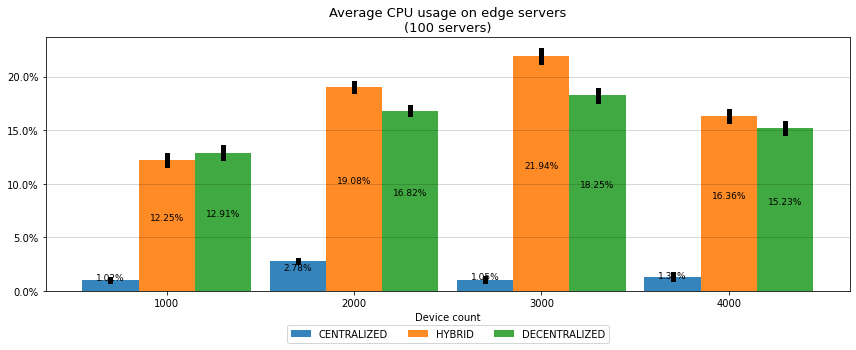

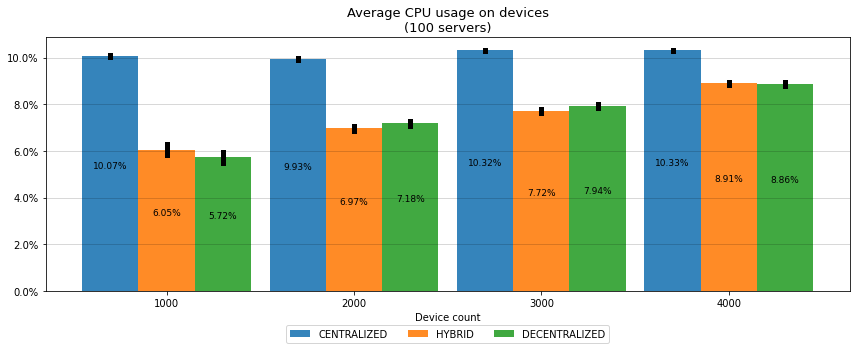

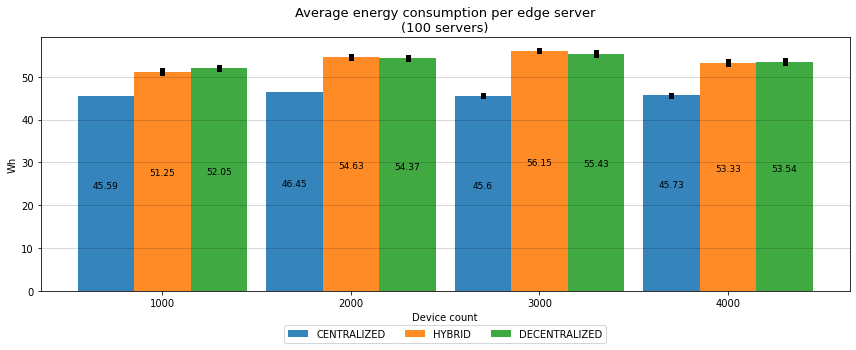

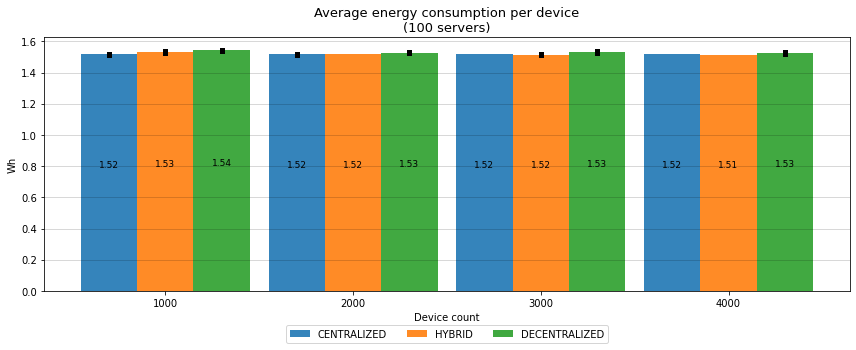

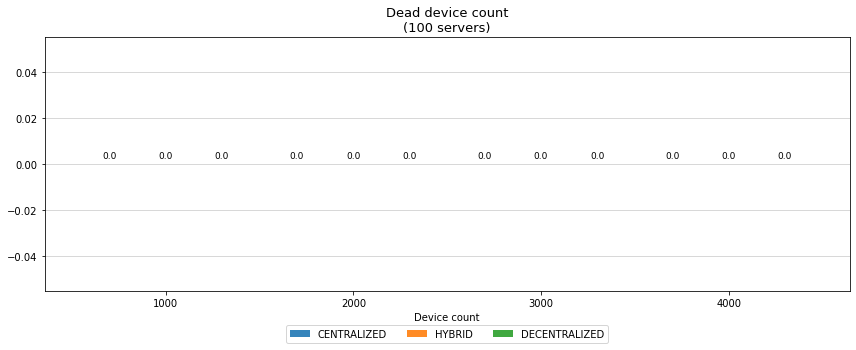

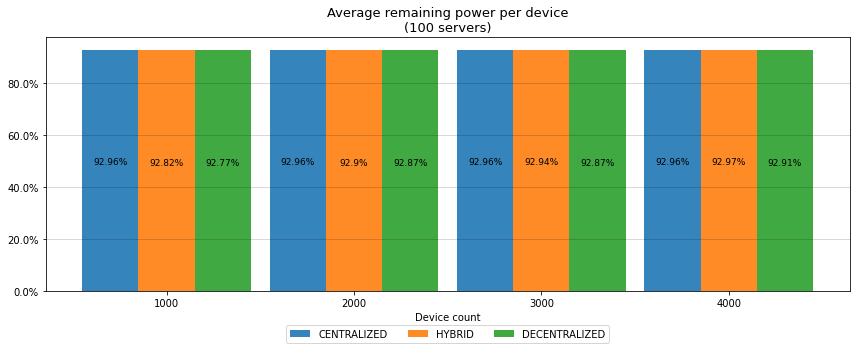

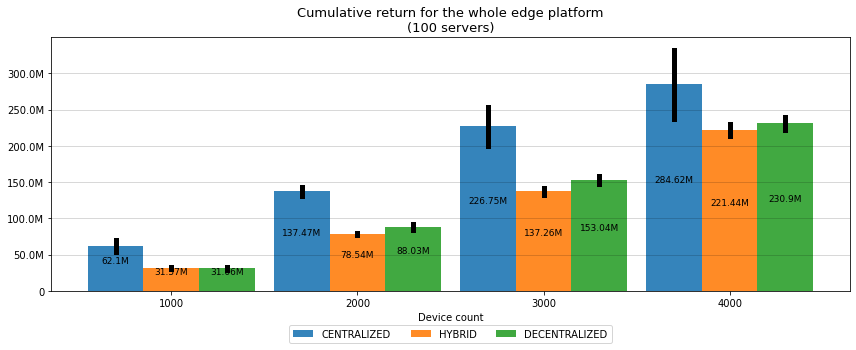

In [5]:
# A dictionary to which all the evaluation results will be collected
evaluation_results = {
    '20 servers': {},
    '100 servers': {}
}

path_to_output = '..\EISim\EISim_output\\'

# Output folders for scenarios with 20 servers (12 scenarios in total)
servers20_folders = [path_to_output + 'C_20results\output_C_20servers_evaluation',
                     path_to_output + 'H_20results\output_H_20servers_evaluation',
                     path_to_output + 'D_20results\output_D_20servers_evaluation'
                    ]

# Output folders for scenarios with 100 servers (12 scenarios in total)
servers100_folders = [path_to_output + 'C_100results\output_C_100servers_evaluation',
                      path_to_output + 'H_100results\output_H_100servers_evaluation',
                      path_to_output + 'D_100results\output_D_100servers_evaluation'
                     ]

parse_results_from_output_folders(servers20_folders, evaluation_results['20 servers'])
parse_results_from_output_folders(servers100_folders, evaluation_results['100 servers'])

plot_eval_results(evaluation_results, path_to_output + 'evaluation_plots')